In [25]:
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [26]:
def GraphPolynomial(p, a, b, samples = 1000):
    x = np.linspace(a, b, samples)
    plt.plot(x, p(x))

def ConstructQFromP(P, l):
    P = np.copy(P)
    P[-1] += 1
    temp = np.poly1d([-1, l, 0])
    return np.polymul(P, temp)

# Finding the Fixed Points
When repelling potential between the particles is not present, we simply need to find the roots of $Q$. We can easily do so just by specifying the coefficients of $P$.</br> 
For example, when $P(q) = 24q^3-30q^2+10q$, $l= 1$, 

Roots of Q' in the interval [0, l]:
[0.35856 0.67671 0.80727]
A graph of Q:


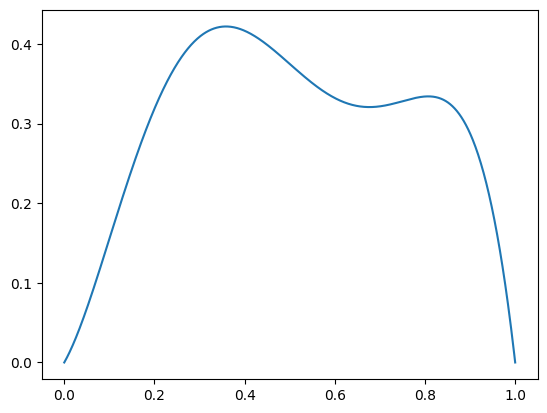

In [27]:
l = 1
P = np.poly1d([24, -30, 10, 0])
Q = ConstructQFromP(P, 1)
Q_prime = np.polyder(Q)
roots = np.roots(Q_prime)
print("Roots of Q' in the interval [0, l]:")
print(np.sort(roots[(roots >= 0) & (roots <= l)]))
print("A graph of Q:")
GraphPolynomial(Q, 0, l)

# Numerical Calculation of the Fixed Points
Now, we move on to the more general case where repelling potential between the particles is present. </br>
We need to solve for ${q_j^{(k)}}, (j = 1, \ldots, d, \; k = 1,\ldots,N)$ in the following set of $Nd$ equations:
$$
\frac{\alpha \cdot Q_j^{'}(q_j^{(k)})}{Q_j(q_j^{(k)})^{\alpha+1}}+2a\beta\mathop{\sum_{n = 1}^N}_{n\neq k}\frac{q_j^{(k)}-q_j^{(n)}}{\left\Vert q^{(k)}-q^{(n)}\right\Vert^{\beta + 2}} = 0
$$

In [28]:
def dH_dq(q, Q, Q_prime, N, d, alpha, a, beta):
    derivative = np.empty((N, d))
    for k in range(0, N):
        for j in range(0, d):
            derivative[k, j] = -alpha * Q_prime[j](q[k, j]) / (Q[j](q[k, j]) ** (alpha + 1))
            sum = 0
            for n in range(0, N):
                if n != k:
                    sum += (q[k, j] - q[n, j]) / (np.linalg.norm(q[k] - q[n])**(beta + 2))
            derivative[k, j] -= 2 * a * beta * sum
    return derivative

def TargetFunction(q, Q, Q_prime, N, d, alpha, a, beta):
    '''
    Here q is an array of size N * d 
    Q is a list of d polynomials
    Q_prime is a list of d polynomials
    q_shape = (N, d)
    alpha, a and beta a scalar parameters
    '''
    q = np.reshape(q, (N, d))
    derivative = dH_dq(q, Q, Q_prime, N, d, alpha, a, beta)  
    return np.ravel(derivative)

def IsCloseToAtLeastOnePoint(L, arr, eps = 0.01):
    for point in L:
        if np.allclose(arr, point, atol = eps):
            return True
    return False

def PointIsInsideBox(q, L):
    return np.all((q >= 0) & (q <= L))

def AllPointsInsideBox(q, L):
    for point in q:
        if not PointIsInsideBox(point, L):
            return False
    return True

def FindFixedPoints(Q, N, d, alpha, a, beta, L, samples = 5):
    '''
    Here L is an ndarray of size d specifying the size of the box
    Q is a list of d polynomials
    '''
    Q_prime = [np.polyder(poly) for poly in Q]
    grids = [np.linspace(0, l, 5) for l in L]
    solutions = []
    for initial_guess in itertools.product(*(N * grids)):
        search_result = sp.optimize.root(lambda q : TargetFunction(q, Q, Q_prime, N, d, alpha, a, beta), initial_guess)
        if search_result.success:
            solution = np.reshape(search_result.x, (N, d))
            if AllPointsInsideBox(solution, L) and not IsCloseToAtLeastOnePoint(solutions, solution):
                solutions.append(solution)

    for solution in solutions:
        print(solution)


For example, when $P_1(q) = P_2(q) = 1$, $l_1 = l_2 = 1$, the fixed points are at:
$$
q^{(1)} = q^{(2)} = (0.5,0.5),
$$
as expected.

In [29]:
P1 = np.poly1d([0])
P2 = np.poly1d([0])
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
N = 2
d = 2
alpha = 1
a = 0
beta = 0
L = np.array([1, 1])
FindFixedPoints(Q, N, d, alpha, a, beta, L)

C:\Users\Ariel\AppData\Local\Temp\ipykernel_11768\88516286.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  derivative[k, j] = -alpha * Q_prime[j](q[k, j]) / (Q[j](q[k, j]) ** (alpha + 1))
C:\Users\Ariel\AppData\Local\Temp\ipykernel_11768\88516286.py:9: RuntimeWarning: invalid value encountered in double_scalars
  sum += (q[k, j] - q[n, j]) / (np.linalg.norm(q[k] - q[n])**(beta + 2))


[[0.50000 0.50000]
 [0.50000 0.50000]]


Another example is $P_1(q) = 1, \; P_2(q) = 24q^3-30q^2+10q$, $l_1 = l_2 = 1$. </br>
There are multiple fixed points.
Each row in the output matrix represents a different particle.

In [30]:
P1 = np.poly1d([0])
P2 = np.poly1d([24, -30, 10, 0])
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
N = 2
d = 2
alpha = 1
a = 8
beta = 5
L = np.array([1, 1])
FindFixedPoints(Q, N, d, alpha, a, beta, L)

C:\Users\Ariel\AppData\Local\Temp\ipykernel_11768\88516286.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  derivative[k, j] = -alpha * Q_prime[j](q[k, j]) / (Q[j](q[k, j]) ** (alpha + 1))
C:\Users\Ariel\AppData\Local\Temp\ipykernel_11768\88516286.py:9: RuntimeWarning: invalid value encountered in double_scalars
  sum += (q[k, j] - q[n, j]) / (np.linalg.norm(q[k] - q[n])**(beta + 2))


[[0.50000 0.07209]
 [0.50000 0.96484]]
[[0.07061 0.35856]
 [0.92939 0.35856]]
[[0.16148 0.12499]
 [0.83852 0.93571]]
[[0.50000 0.96484]
 [0.50000 0.07209]]
[[0.16148 0.93571]
 [0.83852 0.12499]]
[[0.07061 0.80727]
 [0.92939 0.80727]]
[[0.07061 0.67671]
 [0.92939 0.67671]]
[[0.92939 0.35856]
 [0.07061 0.35856]]
[[0.83852 0.12499]
 [0.16148 0.93571]]
[[0.83852 0.93571]
 [0.16148 0.12499]]
[[0.92939 0.80727]
 [0.07061 0.80727]]
[[0.92939 0.67671]
 [0.07061 0.67671]]


# Simulating the Solution of the System

In [31]:
def HamiltonianSystem(state, t, Q, Q_prime, N, d, alpha, a, beta):
    q = state[:N * d]
    p = state[N * d:]
    q = np.reshape(q, (N, d))
    derivative = dH_dq(q, Q, Q_prime, N, d, alpha, a, beta)
    return [*p, *(-np.ravel(derivative))]

def Simulate2DSolution(filename, initial_q, initial_p, t0, t1, dt, Q, Q_prime, N, alpha, a, beta, L):
    t = np.arange(t0, t1, dt)
    fps = 1 / dt
    interval = 1000 / fps
    state0 = np.concatenate((np.ravel(initial_q), np.ravel(initial_p)))
    states = sp.integrate.odeint(lambda state, t: HamiltonianSystem(state, t, Q, Q_prime, N, 2, alpha, a, beta), state0, t)
    ani = animation.FuncAnimation(plt.gcf(), lambda i: Animate(i, states, N, L), frames = len(t), interval = 200)
    writer = animation.FFMpegFileWriter(fps = 40)
    ani.save(filename, writer = writer, dpi = 200)
    plt.close()

def Animate(i, states, N, L):
    plt.clf()
    colors = "rbgcmyk"
    for j in range(N):
        plt.plot(states[i, 2 * j], states[i, 2 * j + 1], colors[j % len(colors)] + 'o', markersize=5)
    plt.xlim([0, L[0]])
    plt.ylim([0, L[1]])


# Example 1
Let us try: 
$$a = 0$$
$$\alpha = 1$$
$$l_1 = l_2 = 1$$
$$P_1(q) = P_2(q) = 1000$$
$$
q^{(1)} = (0.25, 0.75), \quad q^{(2)} = (0.5, 0.5)
$$
$$
p^{(1)} = (1, 2), \quad p^{(2)} = (0, 0)
$$
Although this $P$ doesn't satisfy the requirements, it is nice to see how the box is almost ideal. $(0.5, 0.5)$ is a fixed point.

In [32]:
initial_q = np.array([[0.25, 0.75], [0.5, 0.5]])
initial_p = np.array([[1, 2], [0, 0]])
N = 2
alpha = 1
a = 0
beta = 0
P1 = np.poly1d([1000])
P2 = np.copy(P1)
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
Q_prime = [np.polyder(p) for p in Q]
t0 = 0
tf = 5
dt = 0.01
L = [1, 1]
filename = "Simulation1.mp4"
Simulate2DSolution(filename, initial_q, initial_p, t0, tf, dt, Q, Q_prime, N, alpha, a, beta, L)
video = IPython.display.Video(filename, height = 400)
video

# Example 2
Let us try: 
$$a = 0$$
$$\alpha = 1$$
$$l_1 = l_2 = 1$$
$$P_1(q) = P_2(q) = 0$$
$$
q^{(1)} = (0.25, 0.75), \quad q^{(2)} = (0.5, 0.5)
$$
$$
p^{(1)} = (4, 2), \quad p^{(2)} = (0, 0)
$$
The collision with the sides of the box appears "smooth". $(0.5, 0.5)$ is still a fixed point.

In [33]:
initial_q = np.array([[0.25, 0.75], [0.5, 0.5]])
initial_p = np.array([[4, 2], [0, 0]])
N = 2
alpha = 1
a = 0
beta = 0
P1 = np.poly1d([0])
P2 = np.copy(P1)
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
Q_prime = [np.polyder(p) for p in Q]
t0 = 0
tf = 5
dt = 0.01
L = [1, 1]
filename = "Simulation2.mp4"
Simulate2DSolution(filename, initial_q, initial_p, t0, tf, dt, Q, Q_prime, N, alpha, a, beta, L)
video = IPython.display.Video(filename, height = 400)
video

# Example 3
Let us try: 
$$a = 0$$
$$\alpha = 1$$
$$l_1 = l_2 = 1$$
$$P_1(q) = 24q^3-30q^2+10q, \quad P_2(q) = 0$$
$$
q^{(1)} = (0.25, 0.75), \quad q^{(2)} = (0.5, 0.5)
$$
$$
p^{(1)} = (3, 6), \quad p^{(2)} = (0, 0)
$$
$(0.5, 0.5)$ is not a fixed point anymore.

In [34]:
initial_q = np.array([[0.25, 0.75], [0.5, 0.5]])
initial_p = np.array([[3, 6], [0, 0]])
N = 2
alpha = 1
a = 0
beta = 0
P1 = np.poly1d([24, -30, 10, 0])
P2 = np.poly1d([0])
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
Q_prime = [np.polyder(p) for p in Q]
t0 = 0
tf = 5
dt = 0.01
L = [1, 1]
filename = "Simulation3.mp4"
Simulate2DSolution(filename, initial_q, initial_p, t0, tf, dt, Q, Q_prime, N, alpha, a, beta, L)
video = IPython.display.Video(filename, height = 400)
video

# Example 4
Let us try: 
$$a = 0.1$$
$$\beta = 2$$
$$\alpha = 1$$
$$l_1 = l_2 = 1$$
$$P_1(q) =  P_2(q) = 1000$$
$$
q^{(1)} = (0.35, 0.35), \quad q^{(2)} = (0.5, 0.5)
$$
$$
p^{(1)} = (1, 2), \quad p^{(2)} = (0, 0)
$$
Even though $q^{(2)}$ has no initial momentum, it still starts to move since it is repelled by $q^{(1)}$. $\beta = 2$, like in Coulomb's law.

In [35]:
initial_q = np.array([[0.35, 0.35], [0.55, 0.55]])
initial_p = np.array([[1, 2], [0, 0]])
N = 2
alpha = 1
a = 0.1
beta = 2
P1 = np.poly1d([1000])
P2 = np.poly1d([1000])
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
Q_prime = [np.polyder(p) for p in Q]
t0 = 0
tf = 5
dt = 0.01
L = [1, 1]
filename = "Simulation4.mp4"
Simulate2DSolution(filename, initial_q, initial_p, t0, tf, dt, Q, Q_prime, N, alpha, a, beta, L)
video = IPython.display.Video(filename, height = 400)
video

# Example 5
Let us try: 
$$a = 0.1$$
$$\beta = 2$$
$$\alpha = 1$$
$$l_1 = l_2 = 1$$
$$P_1(q) = P_2(q) = 1000$$
$$
q^{(1)} = (0.35, 0.35), \quad q^{(2)} = (0.55, 0.55), \quad q^{(3)} = (0.25, 0.6), \quad q^{(4)} = (0.75, 0.34)
$$
$$
p^{(1)} = (1, 2), \quad p^{(2)} = (0, 0), \quad p^{(3)} = (0.5, 1), \quad p^{(4)} = (1, 0.5)
$$
Again, but with extra particles.

In [36]:
initial_q = np.array([[0.35, 0.35], [0.55, 0.55], [0.25, 0.6], [0.75, 0.34]])
initial_p = np.array([[1, 2], [0, 0], [0.5, 1], [1, 0.5]])
N = 4
alpha = 1
a = 0.1
beta = 2
P1 = np.poly1d([1000])
P2 = np.poly1d([1000])
Q1 = ConstructQFromP(P1, l)
Q2 = ConstructQFromP(P2, l)
Q = [Q1, Q2]
Q_prime = [np.polyder(p) for p in Q]
t0 = 0
tf = 5
dt = 0.01
L = [1, 1]
filename = "Simulation5.mp4"
Simulate2DSolution(filename, initial_q, initial_p, t0, tf, dt, Q, Q_prime, N, alpha, a, beta, L)
video = IPython.display.Video(filename, height = 400)
video